# Turns out that predicting forest fire size from scant met data is hard.

Every year, there are many wildfires in my native Washington (state, obviously). Many aren't a big deal. They spread anemically and predictibly, and fizzle out in the autumn. Fires like that are a good thing. It's a natural process that is very beneficial to many pine species. Especially in drier areas, it keeps a healthy, disease-resistent forest composed of numerous tree species. Wildfire supression in the past century has contributed to a monoculture of Douglas firs in the Cascades, which has caused diseases like mistletoe and bark beetle to explode. An additional unfortunate aspect of fire supression has been that in many areas, fuel has built up to incredible levels. In such places, when a fire does occur, it ain't the good kind: You get hot fires that kill even old growth trees and sterilize the soil. These kind of fires also take incredible resources to fight. It's a primary reason why the U.S. Forest Service has no money to do things like maintain roads anymore. In addition, they can often threaten property and even lives.

Accurate predictions of fire danger over time can enable managers more accurately target interventions such as burn bans. However, fire prediction isn't easy. 

Obviously, fires like to start in dry and hot conditions. Fire danger depends heavily on precip, humidity, and temperature in the prior several weeks. The thicker or deeper the material, the longer it takes to dry, and the longer it takes to wet during a rain event. This acts as sort of a low-pass filter for fire danger.

Indices based on the meteorological factors are the basis of fire danger assessment. Is it possible to use machine learning to predict fire size based on met data alone? [Cortez and Morais, 2007](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=0ahUKEwiQ3v3d1ZbVAhXKv1QKHQ5GBcgQFggoMAA&url=http%3A%2F%2Fwww.dsi.uminho.pt%2F~pcortez%2Ffires.pdf&usg=AFQjCNGSHS3ULDuB_FmONhRmz5o-1Q8hbA) tried to predict fire size with several regression models on data from 517 fires in the Montesinho Natural Park of Portugal from 2000 to 2003. Their best perfoming model was support vector regression. This is a really interesting dataset to work with. Since it is so small, it poses many challenges that you don't get in the typical Kaggle competition.

It turns out that Portugal could really use better wildfire risk assessment. It is a country bedeviled by wildfires, more than any other country in Europe. It has a great deal of forest. Worse, much of the country is a patchwork of small private plots and public ownership. It's not like the US, where most such land is Forest Service or BLM. This presents a severe problem for management and fire supression. Population loss in rural areas has made much privately owned land overgrown and neglected. In addition, invasive eucalypus trees have taken over many forested areas. Eucalypus is highly flammable. 

Fire risk management has also been ineffective. There has been little emphasis on proven strategies like fire breaks around roads and encouragement of private landowners to clear land around houses. These shortcomings were tragically illustrated this June: During a heat wave with temperatures exceeding $latex 40^\circ C$, [a series of fires](https://en.wikipedia.org/wiki/2017_Portugal_wildfires) started within hours of each other, possibly due to arson. 67 people were killed, most in their cars as the fire swept across a roadway.

The results of Cortez and Morais weren't fantastic. The task of accurately predicting fire size based on only met data is essentially impossible, which the authors note. The spread of fires is often dynamically [chaotic](http://www.pnas.org/content/112/8/2378.full). Fire spread depends on everything from the brush immediately next to the ignition site to whether somebody spilled beer next to the fire pit. Hillslope has a huge effect. Fires don't like to go downhill. In addition, the final burned area obviously depends heavily on the what supression efforts are taken.

However, aggregate fire risk is more predictible, just as the climate is more predictible than the chaotic weather. In this post, I am examining the same data Cortez and Morais used. Instead of trying to predict fire size, I am only trying to estimate the probability of whether a fire start will spread or not. In these data, fires of less than 0.01 hectares are set to zero (this put a big wrinkle and Cortez and Morais' regression efforts, as we shall see). First, we'll go through the data, and then fit a logistic regression and XGBoost model to the data.

In [1]:
import pandas as pd
import scipy as sp
import numpy as np
import sklearn.gaussian_process as gp
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
import scipy.stats.distributions as dist
plt.style.use('ggplot')

/usr/lib64/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Load it, get the column names. Also, let's make a categorical feature for whether the burned area is greater than zero.

In [2]:
fire = pd.read_csv("forestfires.csv")
#shuffle. Set a random seed so we get consistent results.
fire = fire.sample(frac=1,random_state=0)
#make a variable for whether area >0. This is what we will predict.
fire['nonzero'] = fire['area'] > 0
#make another categorical feature for if it is late summer or not.
fire['summer'] = (fire['month']=='aug')|(fire['month']=='sep')
fire.columns

Index([u'X', u'Y', u'month', u'day', u'FFMC', u'DMC', u'DC', u'ISI', u'temp',
       u'RH', u'wind', u'rain', u'area', u'nonzero', u'summer'],
      dtype='object')

## Looking at the data
These data give burned areas of fire starts along with temperature, humidity, wind speed, a binary variable of whether was raining or not, and some fire danger indices based on met data with different time lags.

What conditions are favorable to wildfires? A big thing is moisture content of the fuel, which is primarily affected by temperatures and precip. Shallow, loose leaf litter dries out quickly after rain. Deeper, more compact material, or thicker wood, takes longer to dry out. However, it does not wet as easily. Deeper material therefore is more sensitive to lower-frequency components of temp and precip. Because of this, late summer is the worst time for wildfires.

FFMC is the "fine fuel moisture content," a measure of the moisture content of leaf litter and similar material. In other words, the tinder that can start a fire. DMC is the "Duff moisture code," which is the moisture content of deeper, but not compact organic matter. This gives you an idea of the flammability of deeper layers of organic matter, or slightly thicker woody material. Next, DC is the "drought code," which gives the moisture content of more compact, deeper layers. These measures are important, because forest fires often start at the ground. They get going by smouldering, and eventually something bigger catches on fire. 

Let's plot the temperatures during the fire starts by month:

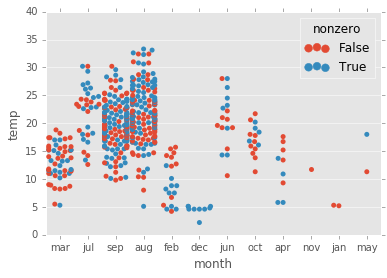

In [3]:
month_means = fire.groupby('month').aggregate(np.mean)
sb.swarmplot(data=fire,x='month', y='temp',hue='nonzero')
plt.show()

Fires definitely like warmer weather. There are more fires when it is hot. Important for our prediction later, we can kind of see a relationship between fire spreading beyond 0.01 hectares ('nonzero') and temperature.

The RH during these fires is pretty consistent throughout the year, except higher in winter and spring. These values are pretty consistent with [average humidity levels](https://weather-and-climate.com/average-monthly-Humidity-perc,santa-barbara-california-us,United-States-of-America) in nearby Bragança.

The Montesihno Natural Park has a pretty typical Mediterranean climate, albeit at a relatively high altitude. You can get a general idea of the climate from the nearby town of [Bragança](https://en.wikipedia.org/wiki/Bragan%C3%A7a,_Portugal#Climate), which is around 500m lower than most of the park. This should mean that temps in the park should run about 2-3 degrees cooler. Precip is heavily concentrated during the winter.

The few fires in the winter months don't really seem to be associated with abnormally warm temperatures. However, they do seem to be associated with abnormally dry conditions. We can see this by plotting the FFMC (loose material moisture content):

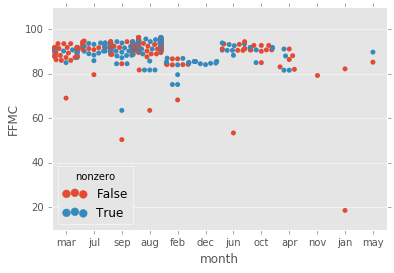

In [4]:
sb.swarmplot(data=fire,x='month', y='FFMC',hue='nonzero')
plt.legend(title='nonzero',loc='lower left')
plt.show()

FFMC doesn't differ much throughout the year, with the exception of a few outliers. It's above 80 for the vast majority of fires, showing that it is a pretty diagnostic measure for fire danger. Given typical Mediterranean winter conditions, I bet usually FFMCs during the winter are more like 30-50 instead of 80-100. They must differ significantly because it is much rainier, more humid, and colder during the winter.

Let's stop and think about the causes of these fires. According to this [paper](https://www.witpress.com/Secure/elibrary/papers/FIVA10/FIVA10022FU1.pdf), arson is the cause of 42% of human-caused wildfires in Portugal. In Spain, only 4% of fires are lightning-triggered, which is probably pretty similar for Portugal. Thus, we can probably guess that a third or more of the fires in Montesihno are due to arson. This could be a good explanation for some of the outliers occuring during low FFMC.

Next let's look at relative humidity **during** these fire events, broken down by month:

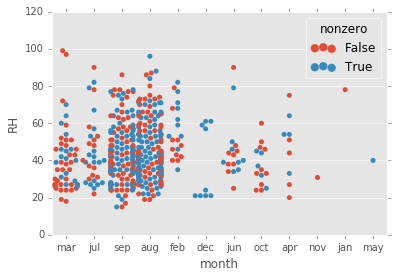

In [5]:
sb.swarmplot(data=fire,x='month',y='RH',hue='nonzero')
plt.show()

The humidity is fairly consistent for all months that have more than a handful of observed fires. May and January have the highest humidity. However, I think that is just an artifact of sample size: Both of these months only have two observed fires. While the RH during fires is nearly consistent throughout the year the [average monthly RH](https://weather-and-climate.com/average-monthly-Humidity-perc,Braganca,Portugal) in Bragança varies greatly throughout the year. It runs about 50% during the summer, 70% in the spring, and 80% in the winter. Just like we saw with the FFMC, this indicates that when fires do occur outside summer, it is usually during abnormally dry periods. 

How about fires by day of the week? Most fires in Portugal are human caused. Since it is a Mediterranean climate, not a humid continental climate, there is very little lightning. We should have more fires on the weekends:

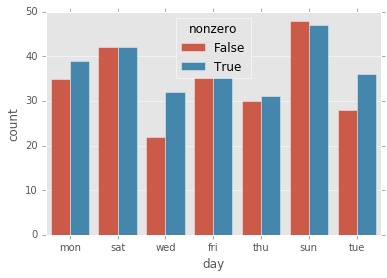

In [6]:
sb.countplot(data=fire,x='day',hue='nonzero')

plt.show()

No big surprise: Sunday has the most fires. Even the vast majority of service industry workers in most European countries have Sunday off, so people can take their kids to the forest and set it on fire. I really would have thought this effect would have been bigger, considering that the vast majority of fires are human-caused. Perhaps arsons are more concentrated during the middle of the week, when there are less visitors. It's also possible that people feel that they can get away with flouting fire-safety regulations (no campfires during burn bans, etc) during the week. Lastly, there also can be time lag between the start of the fire and when it is detected. Fires can sometimes slowly smoulder in leaf matter (next to or below a campfire, say) for a while before actually catching.

Day of the week is probably irrelevant to fire spread. While more fires get started on weekends, the day of the week shouldn't matter to whether they spread significantly or not. To take a look at this, I'm going to get bootstrap estimates of the sampling distribution of the mean of 'nonzero' (whether fires spread beyond 0.01 Ha). This tells us whether the chances of fires spreading actually differs significantly based on day of the week.

There is not an implementation of bootstrapping in Pandas, but it just takes a few lines to write one.

Standard deviation of 'nonzero' by day:
day
fri    0.053467
mon    0.056890
sat    0.053130
sun    0.050630
thu    0.065560
tue    0.064518
wed    0.065534
dtype: float64

Mean of 'nonzero' by day:
day
fri    0.504965
mon    0.527811
sat    0.500869
sun    0.494358
thu    0.508557
tue    0.559875
wed    0.593315
dtype: float64


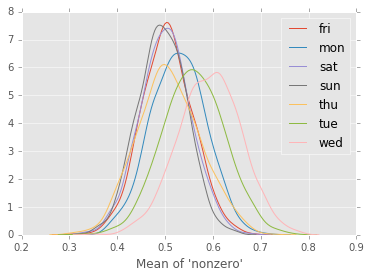

In [35]:
def bootstrap(ser, stat_fun, n_resamps = 500, columns=None, size_resamp=None):
    if size_resamp == None:
        size_resamp = ser.size
    boot_series = pd.Series(np.empty(n_resamps))
    for i in xrange(n_resamps):
        resamp = ser.sample(size_resamp,replace=True)
        boot_series[i] =  stat_fun(resamp)
    return boot_series

#we'll be doing this a couple times, so I'm putting it in a function.
def bootstrap_col(data, grouping_col, boot_col):
    return data.groupby(grouping_col).apply(\
        lambda x: bootstrap(x[boot_col],np.mean,n_resamps=1000)).transpose()

def boot_report(data, grouping_col, boot_col):
    samples = bootstrap_col(data, grouping_col, boot_col)
    for key in samples.columns:
        sb.kdeplot(samples[key])
    print 'Standard deviation of \'nonzero\' by {0}:\n'.format(grouping_col), samples.apply(np.std)
    print '\nMean of \'nonzero\' by {0}:\n'.format(grouping_col), samples.apply(np.mean)
    plt.xlabel("Mean of 'nonzero'")
    plt.show()

boot_report(fire, boot_col='nonzero', grouping_col='day')

We can see that more fires started on Wednesday spread beyond 0.01 hectares (59% versus the mean for all days of 51%). However, it doesn't look significant at all, since this difference is just a bit over one standard deviation of the bootstrap distribution of 'nonzero' for Wednesday. I think we can throw this out, especially considering I already have prior reasons to think it is irrelevant.

Next, we'll look at dependence of spatial location X (integers ranging from 1 to 9) and Y (ranging from 2 (?) to 9) on fire frequency, and fires that start, spread ('nonzero'). First, we'll look at a pivot table to more easily see the counts for each combination of 'X' and 'Y.'

In [8]:
pd.pivot_table(fire,values='nonzero',columns=['X'],index=['Y'],aggfunc=np.sum,fill_value=0)

X,1,2,3,4,5,6,7,8,9
Y,,,,,,,,,
2,4,11,0,0,0,0,0,0,0
3,7,0,1,13,0,9,1,3,0
4,10,17,15,20,13,6,25,1,4
5,4,14,1,10,0,32,3,3,1
6,0,0,0,4,2,1,1,29,1
8,0,0,0,0,0,0,0,1,0
9,0,0,0,0,0,0,0,0,3


Clearly, most fires start in particular areas, probably near roads and such. Let's see if there is a relationship between 'nonzero' and spatial location:

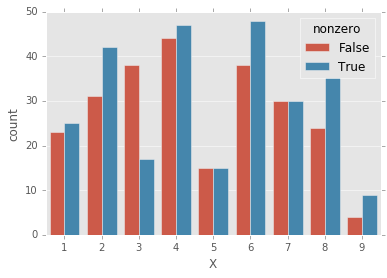

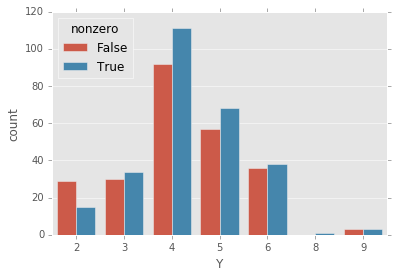

In [9]:
sb.countplot(data=fire,x='X',hue='nonzero')
plt.show()
sb.countplot(data=fire,x='Y',hue='nonzero')
plt.show()

There seems to be a relationship between X and probability of spreading beyond 0.01 hectares. This could be due to different vegetation or any number of reasons. I'll get bootstrap estimates of the standard deviation of the mean of 'nonzero' for each X, to see if the differences are significant. I'll also plot the sampling distribution of the mean of 'nonzero' for each 'X.'

Standard deviation of 'nonzero' by X:
X
1    0.073095
2    0.059174
3    0.061835
4    0.052061
5    0.092471
6    0.052834
7    0.063764
8    0.061514
9    0.127197
dtype: float64

Mean of 'nonzero' by X:
X
1    0.521750
2    0.575973
3    0.310345
4    0.518879
5    0.490500
6    0.554605
7    0.500933
8    0.608328
9    0.694385
dtype: float64


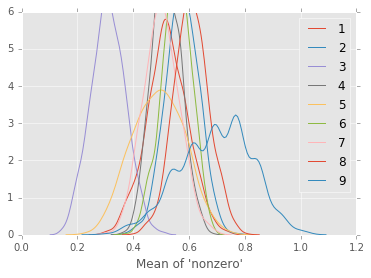

Standard deviation of 'nonzero' by Y:
Y
2    0.072181
3    0.063558
4    0.035024
5    0.043618
6    0.055876
8    0.000000
9    0.199663
dtype: float64

Mean of 'nonzero' by Y:
Y
2    0.341250
3    0.534594
4    0.545300
5    0.542720
6    0.513973
8    1.000000
9    0.507167
dtype: float64


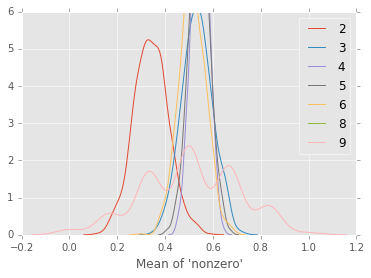

In [36]:
boot_report(fire, 'X', 'nonzero')
boot_report(fire, 'Y', 'nonzero')

It's pretty clear from this that there is a relationship between fire spread and spatial location for X, while Y is a bit more borderline. 

While fire areas are related to X and Y, it is nonlinear and non-monotic. This is a little bit different than met variables, where hotter and drier makes fires bigger. Because of this, we will be one-hot encoding X and Y.

Now let's look at burned areas of the fires. In this dataset, fires burning less than 0.01 hectares (100 sq. meters) are set to zero. About half of fires in this dataset are below this threshold. If we plot the log areas of the fires above this cutoff, it is beautifully normal (i.e., the areas are lognormal):

Fires with area > 0.01 Ha: 52.2243713733 %


/usr/lib64/python2.7/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/usr/lib64/python2.7/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


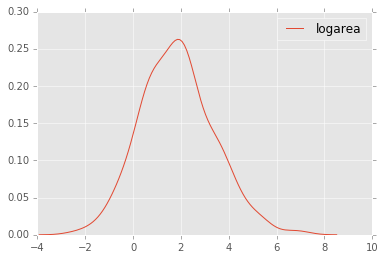

In [11]:
print 'Fires with area > 0.01 Ha:', (100.*fire_nonzero.shape[0])/fire.shape[0],'%'
fire['logarea']=np.log(fire.query('area > 0.')['area'])
sb.kdeplot(fire['logarea'])
plt.show()

An area of 0.01 hectares corresponds to a log area of -4.6, which is off the end of this chart. However, about half of the observed fires have areas of less than 0.01 hectares (area=0, in our data). This points to a very bimodal distribution of fire sizes: either fires catch and really get going, or they fizzle out. This might be like lighting a campfire with a match: One of two things usually happens. Either the match goes out, and your total burned area is a few square millimeters, or the bigger fuel catches, and you have a burned area (hopefully confined to the pit) on the order of a square meter.

This lognormal-ish distribution of areas makes me think that Cortez and Morais' use of a $latex \log(x+1)$ transform was not a great choice. They did this to ameriolate some of the problems with having a huge spike in areas at zero. However, it doesn't actually do much to solve the problem. Worse, it implicitly assumes that areas can be less than zero! Considering we have a great lognormal distribution when the area is greater than zero, why not just work with that?

A compound distribution makes a lot more sense to me:

$latex \Pr(x > 0) \sim \mathrm{Bernoulli}(p)$

$latex \Pr(\log x | x>0) \sim \mathrm{Normal}(\mu,\sigma)$

This also decouples the problem of predicting fire sizes into a classification problem (predict whether size > 0), and a regression problem (predict the size given that it is greater than zero).



Now let's do a pairplot to look at pairwise relationships. To save space, I'm only plotting DC, FFMC, temp, X, Y, and DMC, which look like they are the more relevant variables for predicting fire spread. As the sort of dependent variable, I also am plotting area. The coloring is whether the fire has a nonzero area (e.g. less than 0.01 hectares) or not:

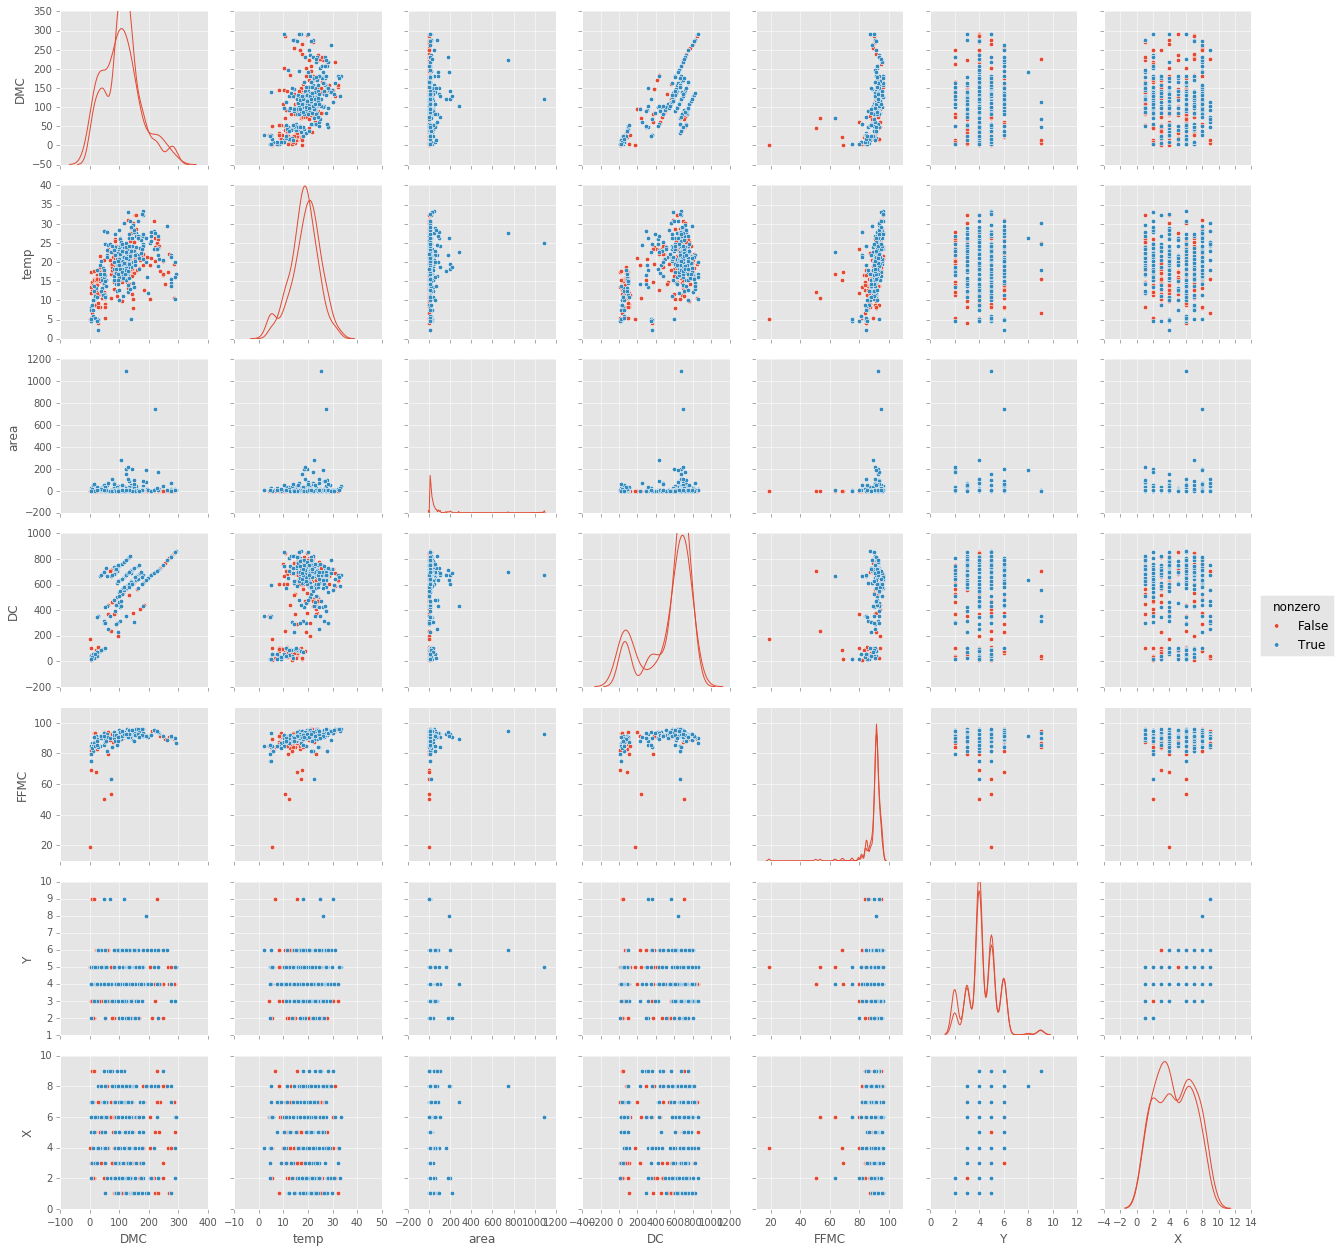

In [33]:
sb.pairplot(data=fire, diag_kind='kde', vars={'DC','FFMC','DMC','temp','X','Y','area'}, hue='nonzero')
plt.show()

The vast majority of fires start with high FFMC (dry conditions), and usually high DC. There's not much of a relationship with wind here. Fast winds can have a huge effect on fires, but wind speeds in these data are all slow; I don't think 10 km/h would do much. 

None of these are great predictors of whether a fire spreads or not ('nonzero'). I can't really see any immediately visible relationships. This does not bode well for my efforts at predicting fire spread, which we will see in the next section.

## Predicting fire spread

Cortez and Marais only used the meterological variables FFMC, DC, DMC, and ISI, and spatial variables X and Y with their best-performing model (support vector regression). Here, I'm going to try logistic regression on with cubic features (after scaling the data), and XGBoost. I'm doing about a 60/40 test/train split, rather than a more standard 80/20, because the data is so small.

This dataset is so small, and it is so noisy, that **fitting the test set is really, really easy.** Reshuffling the data, or tweaking parameters can make a huge difference on the test set fit just by random chance. Implicitly fitting the test set can give misleading estimates of true generalization performance. Therefore, it's really important fit the training set "blind" to the test set.  To do this, I'm using randomized parameter search with 10-fold cross-validation.

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import OneHotEncoder
import scipy.stats.distributions as dist

#number of training points
n_test = 100
pred_features =['RH','FFMC','DC','DMC','ISI','temp','summer','X','Y']
fire_test=fire[0:n_test]
fire_arr = np.array(fire[pred_features])
#One-hot encode X and Y. With 'categorical_features', this can't be put
# in a pipeline. https://github.com/scikit-learn/scikit-learn/issues/8539
oh = OneHotEncoder(categorical_features=[-1,-2],sparse=False)
fire_arr = oh.fit_transform(fire_arr)

#do a test-train split. Already shuffled.
Xtest = np.array(fire_arr[0:n_test,:])
Xtrain = np.array(fire_arr[n_test+1:,:])
Ytest = np.array(fire['nonzero'])[0:n_test]#,np.newaxis]
Ytrain = np.array(fire['nonzero'])[n_test+1:]#,np.newaxis]

#Do regularized logistic regression with cubic features
pipe_log = Pipeline(steps=[('scaler',StandardScaler()),\
                           ('poly',PolynomialFeatures(degree=3)),
                           ('logreg', LogisticRegression(dual=True))])
logistic_param = {'logreg__C':np.logspace(-3,-2,100)}
logistic_cv = RandomizedSearchCV(pipe_log,logistic_param,cv=10,n_iter=30,verbose=10)
logistic_cv.fit(Xtrain,Ytrain)



#no reason not to use a huge number of trees. It's still quick this small.
xgb_model = XGBClassifier(n_estimators=1000)
#cross-validate on lambda (L2 regularzation) and alpha (min gain from splitting).
#also, find the best learning rate for our budget of 100 estimators.
param = {'subsample':np.logspace(-0.3,0,100),'learning_rate':np.logspace(-3,-1.5,100),'reg_lambda':np.logspace(-2,1,100),'reg_alpha':np.logspace(-2,1,100)}
cv_xg = RandomizedSearchCV(xgb_model,param,cv=10,n_iter=100,verbose=10)
cv_xg.fit(Xtrain,Ytrain)
rf_preds=cv_xg.predict(Xtest)
Ytest = np.array(fire['nonzero'])[0:n_test]

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV] logreg__C=0.00343046928631 ......................................
[CV] ....... logreg__C=0.00343046928631, score=0.534884, total=   0.3s
[CV] logreg__C=0.00343046928631 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ....... logreg__C=0.00343046928631, score=0.604651, total=   0.3s
[CV] logreg__C=0.00343046928631 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] ....... logreg__C=0.00343046928631, score=0.500000, total=   0.2s
[CV] logreg__C=0.00343046928631 ......................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s


[CV] ....... logreg__C=0.00343046928631, score=0.452381, total=   0.2s
[CV] logreg__C=0.00343046928631 ......................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s


[CV] ....... logreg__C=0.00343046928631, score=0.609756, total=   0.3s
[CV] logreg__C=0.00343046928631 ......................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s remaining:    0.0s


[CV] ....... logreg__C=0.00343046928631, score=0.560976, total=   0.2s
[CV] logreg__C=0.00343046928631 ......................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.7s remaining:    0.0s


[CV] ....... logreg__C=0.00343046928631, score=0.609756, total=   0.3s
[CV] logreg__C=0.00343046928631 ......................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.0s remaining:    0.0s


[CV] ....... logreg__C=0.00343046928631, score=0.585366, total=   0.3s
[CV] logreg__C=0.00343046928631 ......................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.3s remaining:    0.0s


[CV] ....... logreg__C=0.00343046928631, score=0.682927, total=   0.2s
[CV] logreg__C=0.00343046928631 ......................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.6s remaining:    0.0s


[CV] ....... logreg__C=0.00343046928631, score=0.634146, total=   0.3s
[CV] logreg__C=0.00120450354026 ......................................
[CV] ....... logreg__C=0.00120450354026, score=0.534884, total=   0.3s
[CV] logreg__C=0.00120450354026 ......................................
[CV] ....... logreg__C=0.00120450354026, score=0.627907, total=   0.3s
[CV] logreg__C=0.00120450354026 ......................................
[CV] ....... logreg__C=0.00120450354026, score=0.571429, total=   0.3s
[CV] logreg__C=0.00120450354026 ......................................
[CV] ....... logreg__C=0.00120450354026, score=0.500000, total=   0.1s
[CV] logreg__C=0.00120450354026 ......................................
[CV] ....... logreg__C=0.00120450354026, score=0.634146, total=   0.3s
[CV] logreg__C=0.00120450354026 ......................................
[CV] ....... logreg__C=0.00120450354026, score=0.536585, total=   0.2s
[CV] logreg__C=0.00120450354026 ......................................
[CV] .

[CV] ....... logreg__C=0.00271858824273, score=0.585366, total=   0.2s
[CV] logreg__C=0.00271858824273 ......................................
[CV] ....... logreg__C=0.00271858824273, score=0.682927, total=   0.2s
[CV] logreg__C=0.00271858824273 ......................................
[CV] ....... logreg__C=0.00271858824273, score=0.585366, total=   0.2s
[CV] logreg__C=0.00954548456662 ......................................
[CV] ....... logreg__C=0.00954548456662, score=0.581395, total=   0.4s
[CV] logreg__C=0.00954548456662 ......................................
[CV] ....... logreg__C=0.00954548456662, score=0.604651, total=   0.2s
[CV] logreg__C=0.00954548456662 ......................................
[CV] ....... logreg__C=0.00954548456662, score=0.547619, total=   0.2s
[CV] logreg__C=0.00954548456662 ......................................
[CV] ....... logreg__C=0.00954548456662, score=0.452381, total=   0.3s
[CV] logreg__C=0.00954548456662 ......................................
[CV] .

[CV] ....... logreg__C=0.00453487850813, score=0.560976, total=   0.2s
[CV] logreg__C=0.00453487850813 ......................................
[CV] ....... logreg__C=0.00453487850813, score=0.609756, total=   0.2s
[CV] logreg__C=0.00453487850813 ......................................
[CV] ....... logreg__C=0.00453487850813, score=0.585366, total=   0.2s
[CV] logreg__C=0.00453487850813 ......................................
[CV] ....... logreg__C=0.00453487850813, score=0.682927, total=   0.2s
[CV] logreg__C=0.00453487850813 ......................................
[CV] ....... logreg__C=0.00453487850813, score=0.634146, total=   0.2s
[CV] logreg__C=0.00432876128108 ......................................
[CV] ....... logreg__C=0.00432876128108, score=0.534884, total=   0.3s
[CV] logreg__C=0.00432876128108 ......................................
[CV] ....... logreg__C=0.00432876128108, score=0.604651, total=   0.2s
[CV] logreg__C=0.00432876128108 ......................................
[CV] .

[CV] ....... logreg__C=0.00231012970008, score=0.634146, total=   0.5s
[CV] logreg__C=0.00231012970008 ......................................
[CV] ....... logreg__C=0.00231012970008, score=0.536585, total=   0.5s
[CV] logreg__C=0.00231012970008 ......................................
[CV] ....... logreg__C=0.00231012970008, score=0.609756, total=   0.3s
[CV] logreg__C=0.00231012970008 ......................................
[CV] ....... logreg__C=0.00231012970008, score=0.585366, total=   0.5s
[CV] logreg__C=0.00231012970008 ......................................
[CV] ....... logreg__C=0.00231012970008, score=0.658537, total=   0.4s
[CV] logreg__C=0.00231012970008 ......................................
[CV] ....... logreg__C=0.00231012970008, score=0.585366, total=   0.5s
[CV] logreg__C=0.00135304777458 ......................................
[CV] ....... logreg__C=0.00135304777458, score=0.534884, total=   0.4s
[CV] logreg__C=0.00135304777458 ......................................
[CV] .

[CV] ....... logreg__C=0.00376493580679, score=0.500000, total=   0.2s
[CV] logreg__C=0.00376493580679 ......................................
[CV] ....... logreg__C=0.00376493580679, score=0.452381, total=   0.2s
[CV] logreg__C=0.00376493580679 ......................................
[CV] ....... logreg__C=0.00376493580679, score=0.609756, total=   0.2s
[CV] logreg__C=0.00376493580679 ......................................
[CV] ....... logreg__C=0.00376493580679, score=0.560976, total=   0.2s
[CV] logreg__C=0.00376493580679 ......................................
[CV] ....... logreg__C=0.00376493580679, score=0.609756, total=   0.2s
[CV] logreg__C=0.00376493580679 ......................................
[CV] ....... logreg__C=0.00376493580679, score=0.585366, total=   0.2s
[CV] logreg__C=0.00376493580679 ......................................
[CV] ....... logreg__C=0.00376493580679, score=0.682927, total=   0.2s
[CV] logreg__C=0.00376493580679 ......................................
[CV] .

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.5min finished


In [20]:
fire_test=fire[0:n_test]
fire_test['correct'] = rf_preds == Ytest

print 'Logistic reg. train accuracy: ', (logistic_cv.predict(Xtrain) == Ytrain).mean()
print 'Logistic reg. test accuracy: ', (logistic_cv.predict(Xtest) == Ytest).mean()

print 'Log. reg. Best C: ', logistic_cv.best_params_
print 'XGBoost best params:', cv_xg.best_params_

print 'XGB Test accuracy:', np.mean(fire_test['correct'])
print 'XGB Train accuracy:', (cv_rf.predict(Xtrain)==Ytrain).mean()

Logistic reg. train accuracy:  0.788461538462
Logistic reg. test accuracy:  0.5
Log. reg. Best C:  {'logreg__C': 0.0012045035402587824}
XGBoost best params: {'learning_rate': 0.0035111917342151308, 'subsample': 0.91328444451617741, 'reg_lambda': 0.061359072734131728, 'reg_alpha': 0.18738174228603841}
XGB Test accuracy: 0.59
XGB Train accuracy: 0.925480769231


/usr/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


XGBoost is accurately predicting whether a fire spreads beyond 0.01 hectares (the zero cutoff) or not 59% of the time. **Based on the test/train split, the accuracy can vary between around 55%-70%**. I could take a larger test set, but that sacrifices even more training data, and adds some stochasticity onto the training set anyway. 

Subsampling with XGBoost seems to make it a bit more robust to sampling issues, although random forests actually peformed poorly here. One-hot encoding spatial variables X and Y is crucial: It tends to improve accuracy by several percent.

The logistic regression comes in at 50% accuracy. This seems to be due to the test-train split and the shuffle. Without setting "random_seed=0" in the initial shuffle, I usually get more like 55% accuracy with logistic regression. Keep in mind that this dataset is so noisy that no algorithm on the planet can get good accuracy: There's very important unobserved variables that help determine fire spread. 

Next, let's do another pairplot with the predictive variables versus the predicted probability that a fire size will exceed 0.01 hectares ("predict_prob_nonzero"). 

I'll also plot the feature importances from the random forest.

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Predicted proportion of correct answers: 0.601085
Actual proportion of correct answers: 0.59


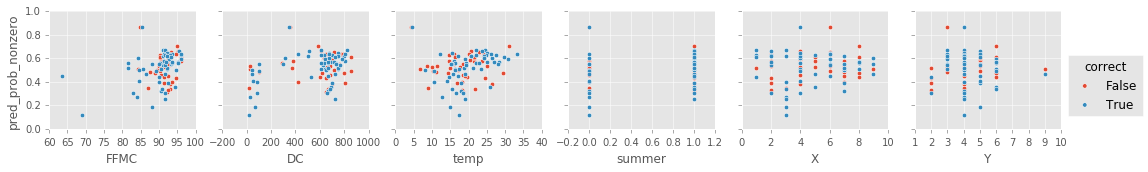

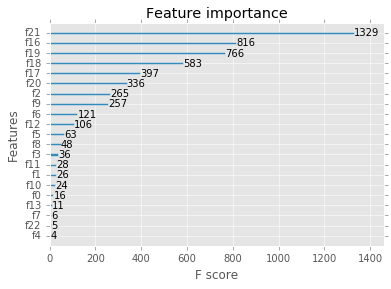

In [32]:
fire_test['pred_prob_nonzero'] = cv_xg.predict_proba(Xtest)[:,1]
print 'Predicted proportion of correct answers:', (np.maximum(fire_test['pred_prob_nonzero'],1.-fire_test['pred_prob_nonzero'])).mean()
print 'Actual proportion of correct answers:', fire_test['correct'].mean()
best_xg = cv_xg.best_estimator_
sb.pairplot(data=fire_test, x_vars=['FFMC','DC','temp','summer','X','Y'],y_vars=['pred_prob_nonzero'],diag_kind='kde',hue='correct')#, plot_kws={"s": 8})
xgb.plot_importance(best_xg)
plt.show()



While this model does not make confident predictions, as it is impossible with these few data, it does seem to be getting reasonable predictions of the *probability of fires spreading beyond 0.01 hectares* given the data. As seen above, the predicted proportion of correct answers that the model gives (blind to the true labels), and the actual proportion of correct answers are within a couple percent. This is an statistically insignificant difference. I think I'm actually lucky that it is this close. The incorrect predictions seem to be more heavily concentrated near the margins ('predict_proba_nonzero' around 0.5), as one would expect. 

The predicted proportion of correct answers, like the predictions of fire size spread, varies based on test-train split. We can get a back-of-the-envelope prediction of the standard deviation of the predicted proportion of correct answers (which corresponds to the actual proportion) as follows: The model gets around 60% correct on average. For a test set of 100, the number of correct answers is binomial with n=100 and p=0.6. The variance is $latex np(1-p)$. By the central limit theorem, the standard deviation of the proportion of incorrect answers is then $latex \sqrt{np(1-p)}/100 \approx 0.05$. This is about in line with the variability of accuracy I've seen with different train/test splits.

If this were a real application, and I wanted to spend more time, I'd bag many models trained on bootstrap resamples of these data. While this wouldn't improve accuracy much, it would provide more stable prediction probabilities. This at least would give a more objective measure of fire risk and uncertainties, even if prediction accuracy isn't significantly improved.

The most important features are a few particular one-hot encoded X and Y features (f21, f16, f19), which explains why one-hot encoding these features is important for performance. Many of the met features are co-linear, so they seem not to get selected as much. FFMC is the most important of these. Fine, tinder-like fuel is important for intitial fire spread.

Whether it is August or September or not ('summer') doesn't really matter, as we can see from the low feature importance (f7). While fires during these times are more likely to spread, the meteorological variables are much more predictive. The fires are more likely to spread because of the weather in the summer, not the fact that it is summer itself.

## Is this useful?

So we obviously can't predict whether an individual fire is going to spread with much confidence. However, it is possible to get decent estimates of the *probability* of a particular fire spreading, given the meager data that we have.

We know from the data that the majority of fire starts are during late summer. This analysis builds on top of that by showing that a fire start during hot, dry weather is more likely to spread than one in colder, wetter weather. Not exactly the most groundbreaking discovery.

However, it's possible for forest managers to get much more and much better data than what we were working with here. Accounting for hill slope and aspect, vegetation, and other factors would help significantly. Models using such data could inform burn bans, for example.

More accurate fire-size predictions could also aid the determination of whether a particular incipient fire needs to be supressed or not, which would lead to a significant cost savings.